# Introductory example to [scikit-image](http://scikit-image.org/) and [scikit-learn](http://scikit-learn.org)

Both libraries are very well-documented and offer a lot of usage examples.
For the purpose of this quick introduction I selected one example of each library and combined them to solve the task of handwritten digit recognition.
The goal is not to provide any understanding of the underlying analysis tools but instead illustrate the high-level capabilities of modern computer-vision and machine-learning libraries.

<img  src="_static/find_digits_and_predict.png" width=300/>

## Identifying regions of interest

In order to perform this task we first need to identify potential digits in a given image.
The [label image regions](http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html) example of the skimage library serves as a basis.
We now load the necessary modules.

In [1]:
import matplotlib.patches as mpatches
from pylab import plt, np
from scipy import ndimage as ndi
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.io import imread
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import closing, square
from skimage.segmentation import clear_border
from skimage.transform import downscale_local_mean
%matplotlib inline

Read and show the image we would like to analyse.

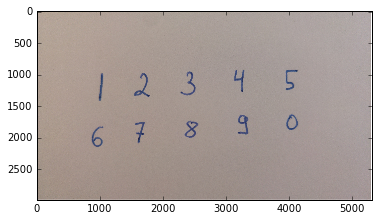

In [2]:
original_image = imread('my_digits/my_digits_3.jpg')
plt.imshow(original_image, interpolation='none')

We convert the color image to gray scale according to luminance and invert it.
Furthermore, as the image is of high resolution we downscale it to reduce artifacts and increase computation speed.

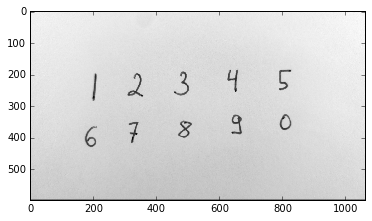

In [3]:
image = rgb2gray(original_image)
# image = np.mean(original_image, axis=2)
image = downscale_local_mean(image, (5, 5))
image = image / np.max(image) * 256
image = np.max(image) - image
plt.imshow(image, cmap='gray_r', interpolation='none')

Next, we create binarized version of the image using the [Otsu method](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.threshold_otsu) and [fill the holes](http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.morphology.binary_fill_holes.html) in it.
We do this in order to create 'blobs' that we can easily recognize.
In a last step we clear the border of the image in order to not run in into trouble there.

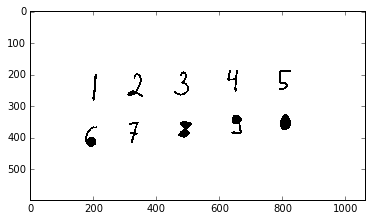

In [4]:
# binarize
global_thresh = threshold_otsu(image)
binary_global = image > global_thresh
# fill holes
bw = ndi.binary_fill_holes(binary_global)
cleared = bw.copy()
clear_border(cleared)
plt.imshow(cleared, cmap='gray_r', interpolation='none')

This pre-processed image we now use to [label](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) the connected regions of the image.
We do this and show the identified regions of interest as overlay.
The properties of each region of the labeled image can easily be accessed with [regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) function (maybe familiar from MatLab).

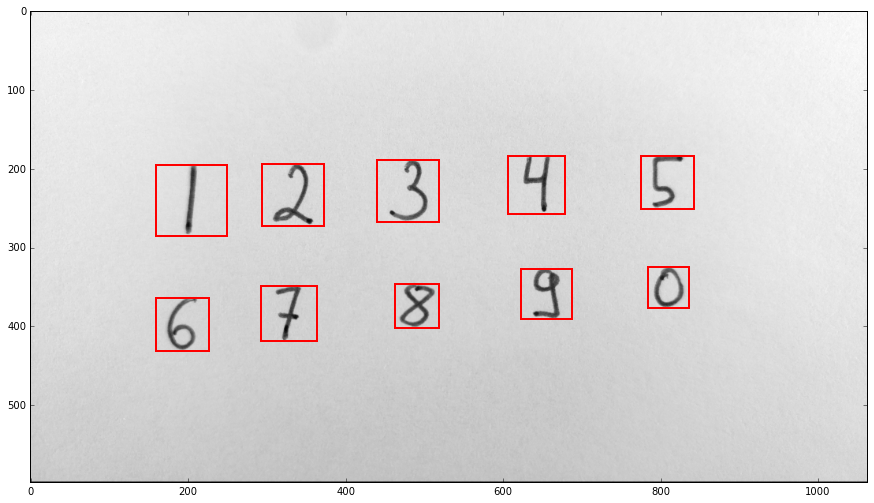

In [5]:
label_image = label(cleared)
# create a larger figure and show the segmentation result
plt.figure(figsize=(15,10))
plt.imshow(image, cmap='gray_r')
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    # make regions square
    maxwidth = np.max([maxr - minr, maxc - minc])
    minr, maxr = int(0.5 * ((maxr + minr) - maxwidth)) - 1, int(0.5 * ((maxr + minr) + maxwidth)) + 1
    minc, maxc = int(0.5 * ((maxc + minc) - maxwidth)) - 1, int(0.5 * ((maxc + minc) + maxwidth)) + 1
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    plt.gca().add_patch(rect)
plt.show()

## Recognizing the digits within the ROIs with sklearn

Having now identified the regions of interest within our image we now turn to the problem of recognizing the digit within them.
We use an example dataset of sklearn that relies on the [Pen-Based Recognition of Handwritten Digits Data Set](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits).
It is a digit database consisting of 250 samples from 44 (english) writers.
Each sample is a 8x8 image of a number.

Following the [Recognizing hand-written digits example](http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html) from sklearn we train a [SVM](https://en.wikipedia.org/wiki/Support_vector_machine) with the data set.

In [48]:
from sklearn import datasets
from sklearn import svm, metrics
from find_digits_and_predict import show_prediction_result

n_samples = len(digits.images)
digits = datasets.load_digits()
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(list(digits.data[:n_samples / 2]) + [np.ravel(img.T) for img in digits.images[:n_samples / 2]], 
        np.array(list(digits.target[:n_samples / 2]) + list(digits.target[:n_samples / 2])))

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False)

In [51]:
# Now predict the value of the digit on the second half:
expected = list(digits.target[n_samples / 2:]) + list(digits.target[n_samples / 2:])
predicted = clf.predict(list(digits.data[n_samples / 2:]) + [np.ravel(img.T) for img in digits.images[n_samples / 2:]])

In [52]:
print len(expected), len(predicted)

1798 1798


Classification report for classifier SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=0.001, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      0.99      0.99       176
          1       0.99      0.96      0.97       182
          2       0.99      0.99      0.99       172
          3       0.98      0.90      0.94       182
          4       0.99      0.96      0.97       184
          5       0.95      0.96      0.95       182
          6       0.99      0.99      0.99       182
          7       0.98      0.99      0.98       178
          8       0.94      0.99      0.96       176
          9       0.91      0.98      0.94       184

avg / total       0.97      0.97      0.97      1798


Confusion matrix:
[[174   0   0   0   2   0   0   0   0   0]
 [  0 174   2   0   0   0   0   0   4   2]
 [  0   0 170   2   0   0

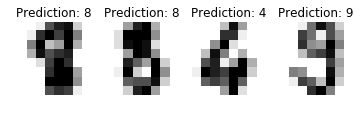

In [53]:
print("Classification report for classifier %s:\n%s\n"
      % (clf, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

images_and_predictions = list(zip(digits.images[n_samples / 2:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()

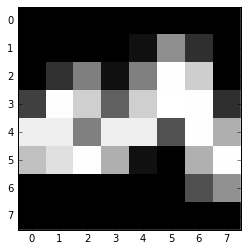

In [24]:
plt.imshow(digits.images[2].T, cmap='gray', interpolation='none')

In [23]:
digits.target[2]

2

In [41]:
clf.predict(np.ravel(digits.images[2].T))

array([2])

We rescale our identified regions to match the 8x8 input images of the training set and apply the classifier to them to get a prediction of the written digit.

ValueError: zero-size array to reduction operation minimum which has no identity

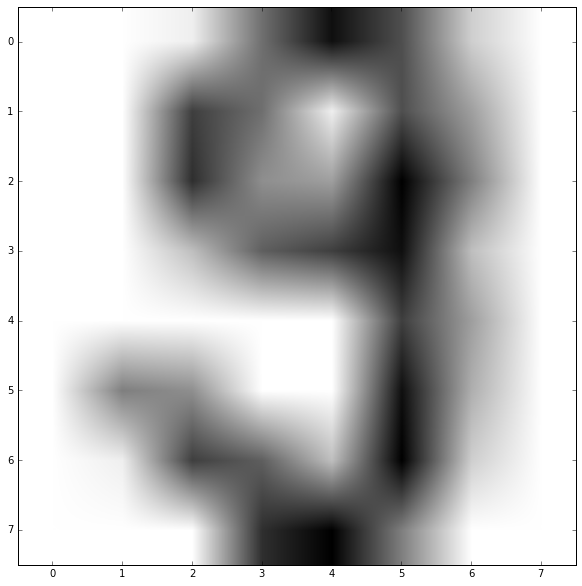

In [54]:
candidates, predictions = show_prediction_result(image, label_image, clf)

So in the end, we were able to identify image regions and written number so some accuracy by basically following the examples of the libraries.
I also notices, that my handwritten 4 obviously differs from the usual way.

Finally, let us have a look at what the classifier actually "sees" to appreciate the difficulty of the task.

In [9]:
clf.predict(candidates[0].reshape(-1))

array([9])

prediction: [9]


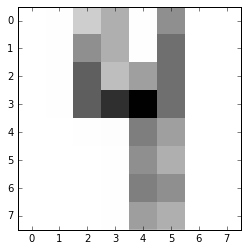

prediction: [5]


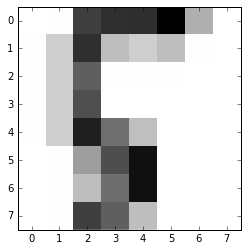

prediction: [3]


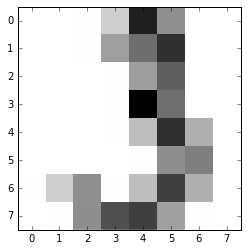

prediction: [2]


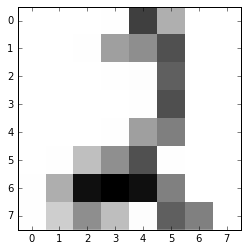

prediction: [1]


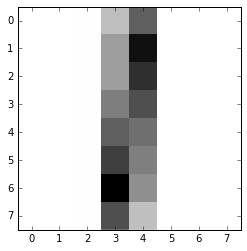

prediction: [0]


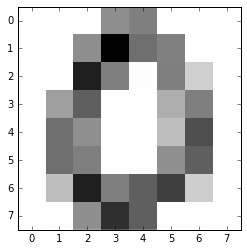

prediction: [9]


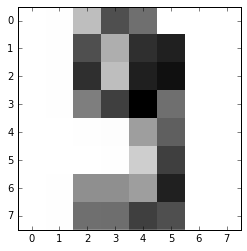

prediction: [8]


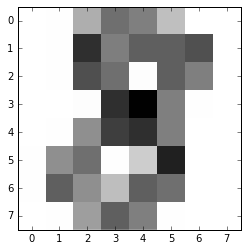

prediction: [7]


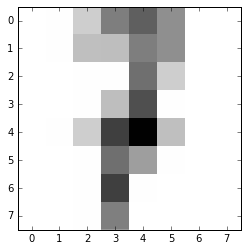

prediction: [6]


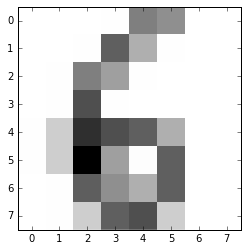

In [8]:
for idx in range(len(candidates)):
    plt.imshow(candidates[idx], cmap='gray_r', interpolation='none')
    print "prediction:", predictions[idx]
    plt.show()